In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
df = pd.read_csv('/content/AirPassengers.csv')

In [3]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
print(df.dtypes)
print(df.describe())

Month          object
#Passengers     int64
dtype: object
       #Passengers
count   144.000000
mean    280.298611
std     119.966317
min     104.000000
25%     180.000000
50%     265.500000
75%     360.500000
max     622.000000


In [5]:
df['Month'] = pd.to_datetime(df['Month'])

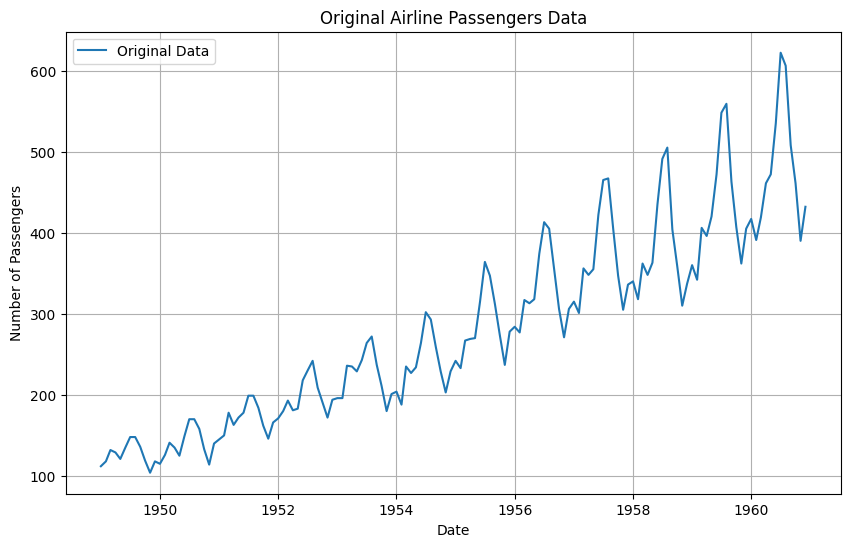

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(df['Month'], df['#Passengers'], label='Original Data')
plt.title('Original Airline Passengers Data')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
df.loc[:, '#Passengers'] = scaler.fit_transform(df['#Passengers'].values.reshape(-1,1))

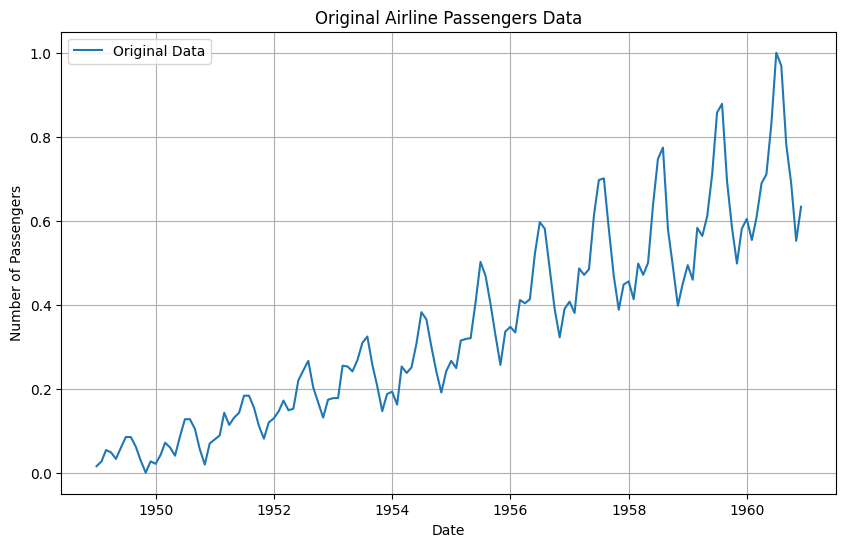

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(df['Month'], df['#Passengers'], label='Original Data')
plt.title('Original Airline Passengers Data')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()

**Visualizing data**

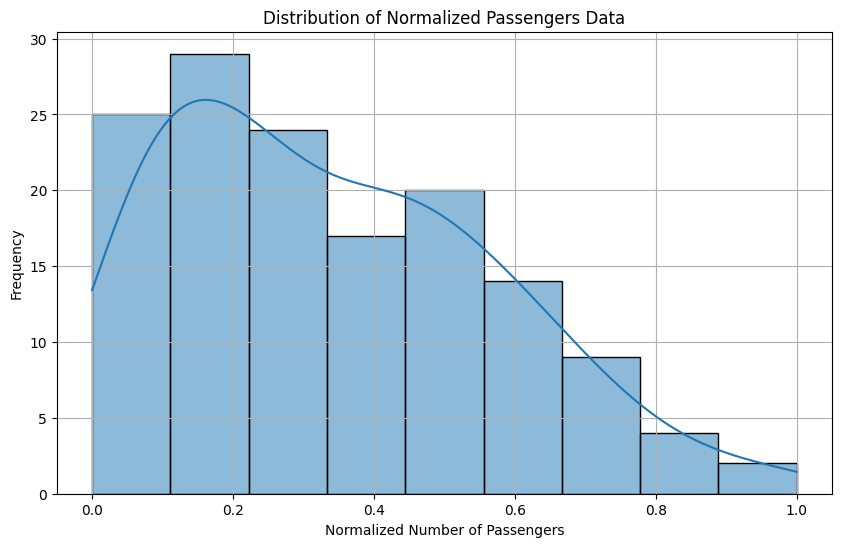

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(df['#Passengers'], kde=True)
plt.title('Distribution of Normalized Passengers Data')
plt.xlabel('Normalized Number of Passengers')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

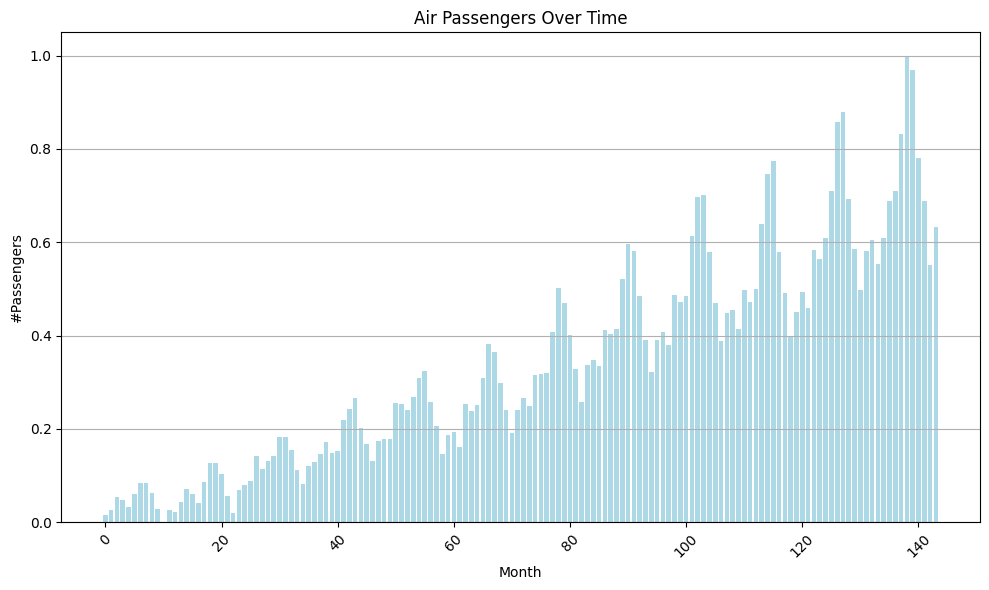

In [10]:
plt.figure(figsize=(10, 6))
plt.bar(df.index, df['#Passengers'], color='lightblue')
plt.title('Air Passengers Over Time')
plt.xlabel('Month')
plt.ylabel('#Passengers')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

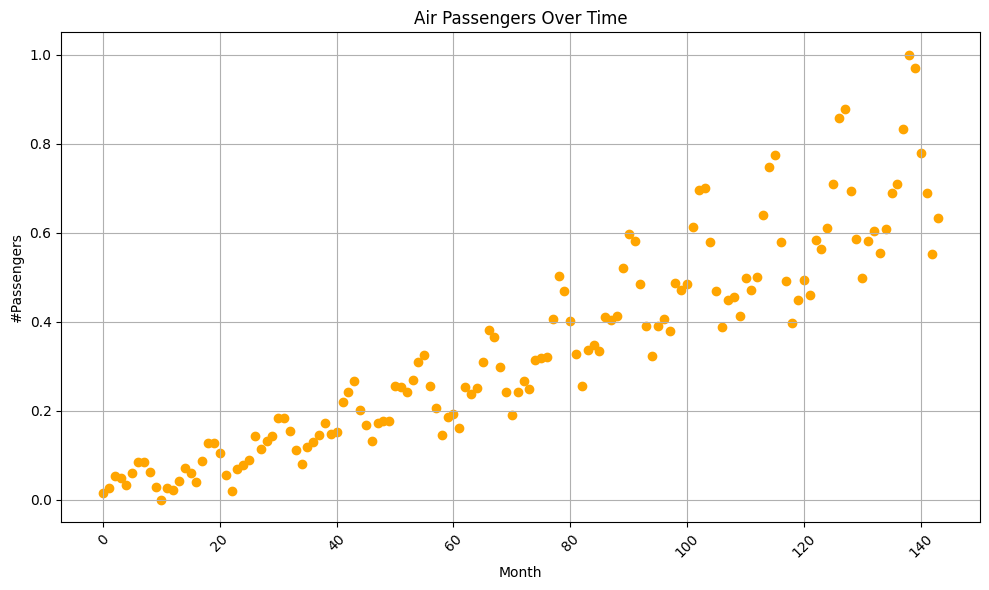

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['#Passengers'], color='orange')
plt.title('Air Passengers Over Time')
plt.xlabel('Month')
plt.ylabel('#Passengers')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

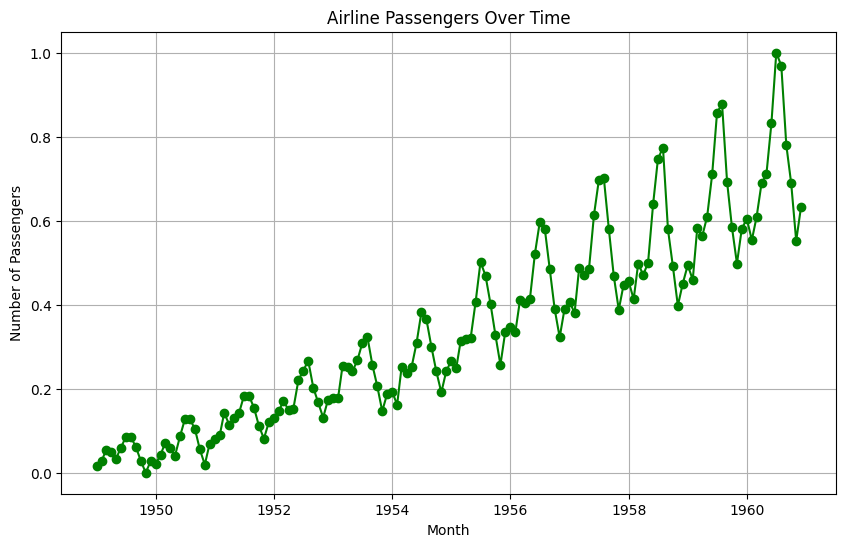

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(df['Month'], df['#Passengers'], marker='o', color='green')
plt.title('Airline Passengers Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Passengers')
plt.grid(True)
plt.show()


In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(1, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [14]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [15]:
def train_model(model, trainX, trainY, validationX, validationY, num_epochs=150, learning_rate=0.001):
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')
    best_model = None
    best_hidden_dim = None

    train_losses = []
    validation_losses = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(trainX)
        loss = loss_function(outputs.view(-1), trainY)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            validation_outputs = model(validationX)
            val_loss = loss_function(validation_outputs.view(-1), validationY)

        train_losses.append(loss.item())
        validation_losses.append(val_loss.item())

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict().copy()
            best_hidden_dim = model.hidden_dim

        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

    plt.plot(train_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return best_model, best_hidden_dim

In [16]:
train_ratio = 0.7
test_ratio = 0.2
validation_ratio = 0.1

train_size = int(len(df) * train_ratio)
test_size = int(len(df) * test_ratio)
validation_size = len(df) - train_size - test_size

train_data = df[:train_size].copy()
test_data = df[train_size:train_size+test_size].copy()
validation_data = df[train_size+test_size:].copy()

In [17]:
look_back = 1
trainX, trainY = create_dataset(train_data[['#Passengers']].values, look_back)
testX, testY = create_dataset(test_data[['#Passengers']].values, look_back)
validationX, validationY = create_dataset(validation_data[['#Passengers']].values, look_back)

trainX = torch.from_numpy(trainX).float().view(-1, 1, 1)
trainY = torch.from_numpy(trainY).float()
testX = torch.from_numpy(testX).float().view(-1, 1, 1)
testY = torch.from_numpy(testY).float()
validationX = torch.from_numpy(validationX).float().view(-1, 1, 1)
validationY = torch.from_numpy(validationY).float()

Training model with hidden_dim=64 and lr=0.001
Epoch [20/150], Training Loss: 0.0192, Validation Loss: 0.2408
Epoch [40/150], Training Loss: 0.0181, Validation Loss: 0.2082
Epoch [60/150], Training Loss: 0.0168, Validation Loss: 0.2039
Epoch [80/150], Training Loss: 0.0153, Validation Loss: 0.1785
Epoch [100/150], Training Loss: 0.0135, Validation Loss: 0.1557
Epoch [120/150], Training Loss: 0.0113, Validation Loss: 0.1258
Epoch [140/150], Training Loss: 0.0088, Validation Loss: 0.0929


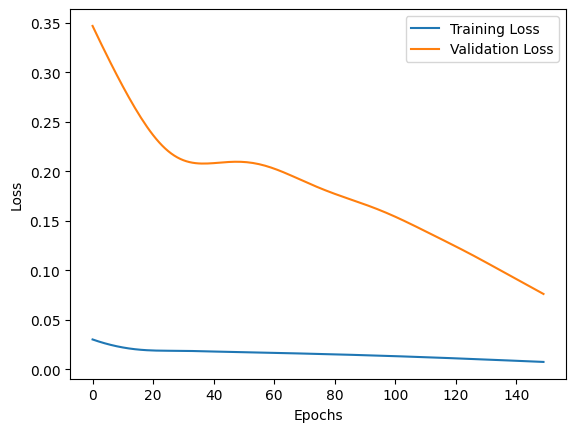

Training model with hidden_dim=64 and lr=0.01
Epoch [20/150], Training Loss: 0.0157, Validation Loss: 0.1873
Epoch [40/150], Training Loss: 0.0060, Validation Loss: 0.0475
Epoch [60/150], Training Loss: 0.0024, Validation Loss: 0.0196
Epoch [80/150], Training Loss: 0.0021, Validation Loss: 0.0108
Epoch [100/150], Training Loss: 0.0021, Validation Loss: 0.0117
Epoch [120/150], Training Loss: 0.0021, Validation Loss: 0.0111
Epoch [140/150], Training Loss: 0.0021, Validation Loss: 0.0109


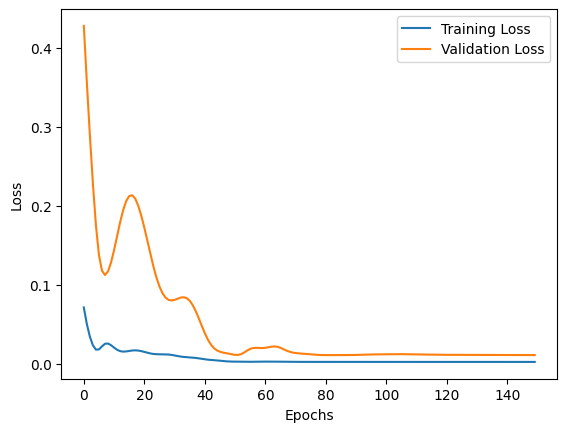

Training model with hidden_dim=64 and lr=0.1
Epoch [20/150], Training Loss: 0.0137, Validation Loss: 0.1085
Epoch [40/150], Training Loss: 0.0024, Validation Loss: 0.0097
Epoch [60/150], Training Loss: 0.0022, Validation Loss: 0.0097
Epoch [80/150], Training Loss: 0.0020, Validation Loss: 0.0105
Epoch [100/150], Training Loss: 0.0020, Validation Loss: 0.0116
Epoch [120/150], Training Loss: 0.0020, Validation Loss: 0.0122
Epoch [140/150], Training Loss: 0.0020, Validation Loss: 0.0126


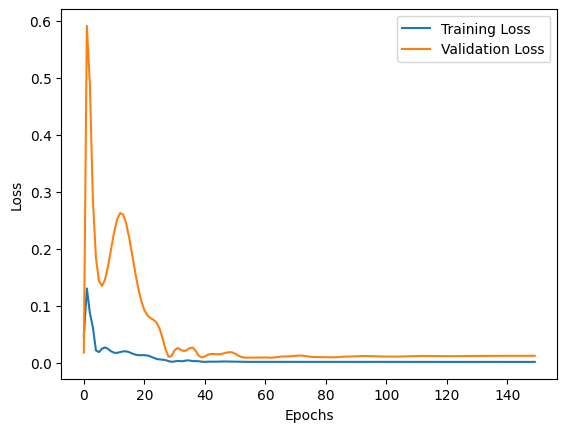

Training model with hidden_dim=128 and lr=0.001
Epoch [20/150], Training Loss: 0.0298, Validation Loss: 0.3185
Epoch [40/150], Training Loss: 0.0159, Validation Loss: 0.1876
Epoch [60/150], Training Loss: 0.0151, Validation Loss: 0.1612
Epoch [80/150], Training Loss: 0.0137, Validation Loss: 0.1590
Epoch [100/150], Training Loss: 0.0122, Validation Loss: 0.1339
Epoch [120/150], Training Loss: 0.0105, Validation Loss: 0.1120
Epoch [140/150], Training Loss: 0.0084, Validation Loss: 0.0854


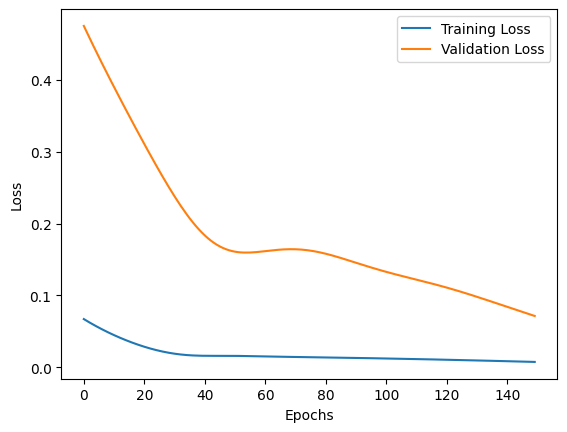

Training model with hidden_dim=128 and lr=0.01
Epoch [20/150], Training Loss: 0.0120, Validation Loss: 0.0867
Epoch [40/150], Training Loss: 0.0024, Validation Loss: 0.0160
Epoch [60/150], Training Loss: 0.0022, Validation Loss: 0.0106
Epoch [80/150], Training Loss: 0.0021, Validation Loss: 0.0124
Epoch [100/150], Training Loss: 0.0021, Validation Loss: 0.0109
Epoch [120/150], Training Loss: 0.0021, Validation Loss: 0.0109
Epoch [140/150], Training Loss: 0.0021, Validation Loss: 0.0105


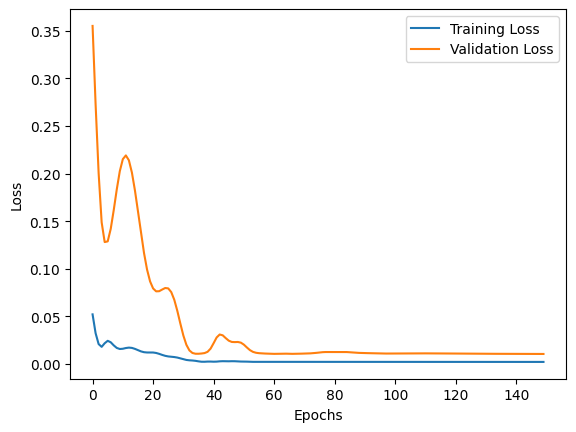

Training model with hidden_dim=128 and lr=0.1
Epoch [20/150], Training Loss: 0.0151, Validation Loss: 0.0746
Epoch [40/150], Training Loss: 0.0020, Validation Loss: 0.0100
Epoch [60/150], Training Loss: 0.0021, Validation Loss: 0.0130
Epoch [80/150], Training Loss: 0.0020, Validation Loss: 0.0124
Epoch [100/150], Training Loss: 0.0020, Validation Loss: 0.0123
Epoch [120/150], Training Loss: 0.0020, Validation Loss: 0.0118
Epoch [140/150], Training Loss: 0.0020, Validation Loss: 0.0118


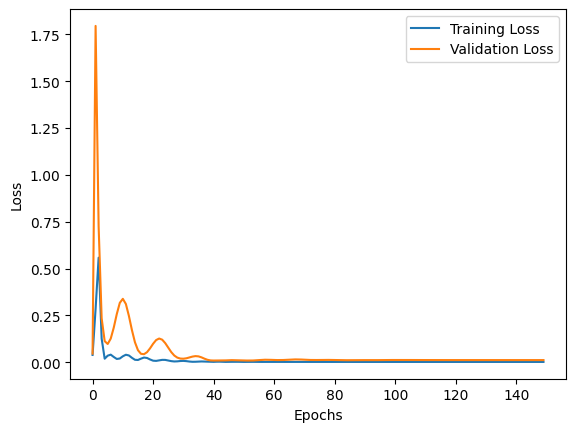

Training model with hidden_dim=256 and lr=0.001
Epoch [20/150], Training Loss: 0.0311, Validation Loss: 0.3225
Epoch [40/150], Training Loss: 0.0168, Validation Loss: 0.1553
Epoch [60/150], Training Loss: 0.0145, Validation Loss: 0.1704
Epoch [80/150], Training Loss: 0.0130, Validation Loss: 0.1463
Epoch [100/150], Training Loss: 0.0112, Validation Loss: 0.1203
Epoch [120/150], Training Loss: 0.0091, Validation Loss: 0.0938
Epoch [140/150], Training Loss: 0.0068, Validation Loss: 0.0646


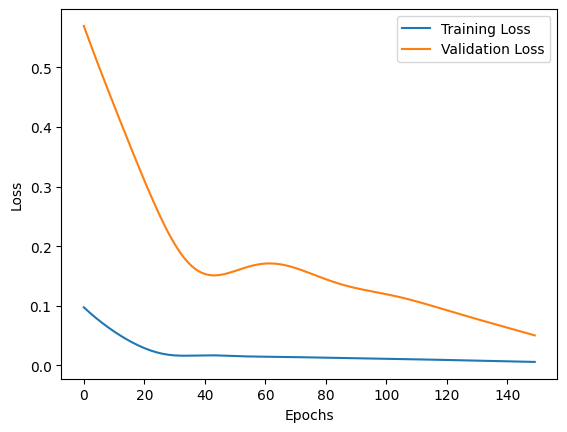

Training model with hidden_dim=256 and lr=0.01
Epoch [20/150], Training Loss: 0.0084, Validation Loss: 0.0831
Epoch [40/150], Training Loss: 0.0030, Validation Loss: 0.0214
Epoch [60/150], Training Loss: 0.0021, Validation Loss: 0.0105
Epoch [80/150], Training Loss: 0.0021, Validation Loss: 0.0110
Epoch [100/150], Training Loss: 0.0021, Validation Loss: 0.0110
Epoch [120/150], Training Loss: 0.0021, Validation Loss: 0.0105
Epoch [140/150], Training Loss: 0.0020, Validation Loss: 0.0103


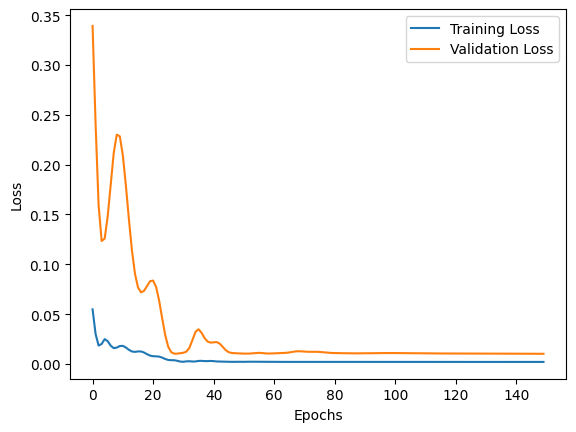

Training model with hidden_dim=256 and lr=0.1
Epoch [20/150], Training Loss: 0.0105, Validation Loss: 0.0811
Epoch [40/150], Training Loss: 0.0054, Validation Loss: 0.0868
Epoch [60/150], Training Loss: 0.0031, Validation Loss: 0.0465
Epoch [80/150], Training Loss: 0.0021, Validation Loss: 0.0197
Epoch [100/150], Training Loss: 0.0020, Validation Loss: 0.0135
Epoch [120/150], Training Loss: 0.0020, Validation Loss: 0.0152
Epoch [140/150], Training Loss: 0.0020, Validation Loss: 0.0154


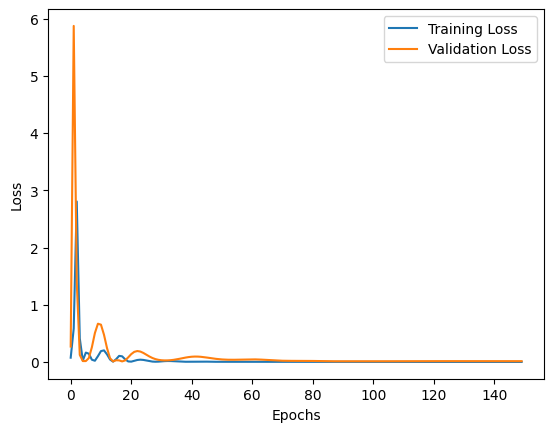

Training model with hidden_dim=512 and lr=0.001
Epoch [20/150], Training Loss: 0.0173, Validation Loss: 0.1810
Epoch [40/150], Training Loss: 0.0151, Validation Loss: 0.1835
Epoch [60/150], Training Loss: 0.0125, Validation Loss: 0.1336
Epoch [80/150], Training Loss: 0.0089, Validation Loss: 0.0937
Epoch [100/150], Training Loss: 0.0049, Validation Loss: 0.0422
Epoch [120/150], Training Loss: 0.0025, Validation Loss: 0.0132
Epoch [140/150], Training Loss: 0.0021, Validation Loss: 0.0107


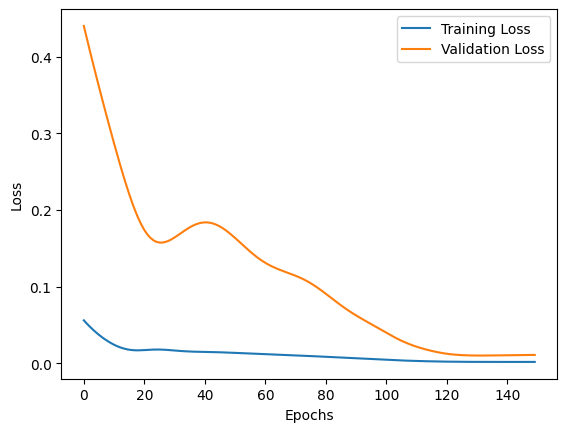

Training model with hidden_dim=512 and lr=0.01
Epoch [20/150], Training Loss: 0.0062, Validation Loss: 0.0389
Epoch [40/150], Training Loss: 0.0024, Validation Loss: 0.0144
Epoch [60/150], Training Loss: 0.0021, Validation Loss: 0.0108
Epoch [80/150], Training Loss: 0.0021, Validation Loss: 0.0105
Epoch [100/150], Training Loss: 0.0021, Validation Loss: 0.0107
Epoch [120/150], Training Loss: 0.0020, Validation Loss: 0.0104
Epoch [140/150], Training Loss: 0.0020, Validation Loss: 0.0102


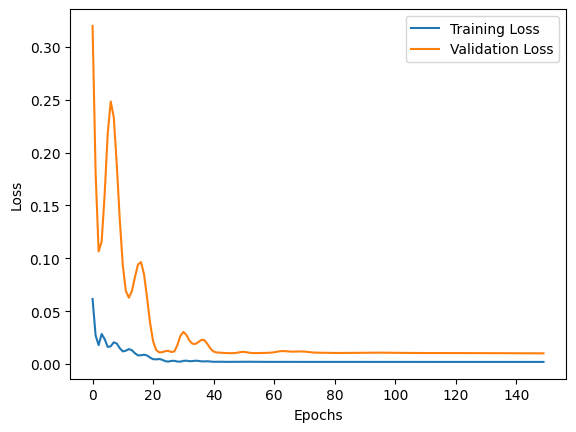

Training model with hidden_dim=512 and lr=0.1
Epoch [20/150], Training Loss: 0.1707, Validation Loss: 0.0232
Epoch [40/150], Training Loss: 0.0092, Validation Loss: 0.0160
Epoch [60/150], Training Loss: 0.0044, Validation Loss: 0.0295
Epoch [80/150], Training Loss: 0.0022, Validation Loss: 0.0182
Epoch [100/150], Training Loss: 0.0020, Validation Loss: 0.0152
Epoch [120/150], Training Loss: 0.0020, Validation Loss: 0.0151
Epoch [140/150], Training Loss: 0.0020, Validation Loss: 0.0151


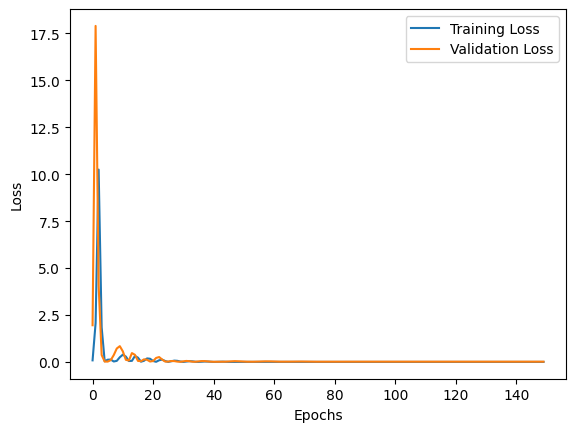

In [18]:
hidden_dims = [64, 128, 256, 512]
learning_rates = [0.001, 0.01, 0.1]

best_model = None
best_val_loss = float('inf')
best_hidden_dim = None

for hidden_dim in hidden_dims:
    for lr in learning_rates:
        print(f"Training model with hidden_dim={hidden_dim} and lr={lr}")
        model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, output_dim=1)
        trained_model, best_hidden_dim = train_model(model, trainX, trainY, validationX, validationY, num_epochs=150, learning_rate=lr)

        model.eval()
        with torch.no_grad():
            validation_outputs = model(validationX)
            val_loss = nn.MSELoss()(validation_outputs.view(-1), validationY)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = trained_model

In [19]:
torch.save(best_model, 'best_model.pth')

best_model = LSTMModel(input_dim=1, hidden_dim=best_hidden_dim, output_dim=1)
best_model.load_state_dict(torch.load('best_model.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [20]:
best_model.eval()
with torch.no_grad():
    test_predict_best = best_model(testX)

test_predict_best = scaler.inverse_transform(test_predict_best.numpy())

In [21]:
mse_best = mean_squared_error(testY, test_predict_best)
print('Mean Squared Error (MSE) for the best model:', mse_best)

rmse_best = math.sqrt(mse_best)
print('Root Mean Squared Error (RMSE) for the best model:', rmse_best)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape_best = mean_absolute_percentage_error(testY, test_predict_best)
print('Mean Absolute Percentage Error (MAPE) for the best model:', mape_best)

Mean Squared Error (MSE) for the best model: 149559.98
Root Mean Squared Error (RMSE) for the best model: 386.7298596889048
Mean Absolute Percentage Error (MAPE) for the best model: 71402.685546875
